In [1]:
import sys
from outletsBiasRatings import outletsBiasRatingsAllSides,outletAbbreviationToFullName
from matplotlib.pyplot import *
import  matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
from joblib import Parallel, delayed
from transformers import pipeline, AutoTokenizer 
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import transformers
from sklearn.model_selection import train_test_split
import dataframe_image as dfi
from sklearn.metrics import cohen_kappa_score, balanced_accuracy_score, matthews_corrcoef
import sklearn

In [2]:
BATCH_SIZE=64
MAX_LENGTH=64

RANDOM_SEED = 2
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

USE_GPU=1
class_names = ["anger", "disgust", "fear", "joy", "neutral","sadness", "surprise"]

## Loading sentiment analysis pipeline from local store

In [3]:
from transformers import pipeline
classifier = pipeline(task='sentiment-analysis',model="./j-hartmann/emotion-english-distilroberta-base",
                             device=0)#gpu device=0, #cpu device=-1
prediction = classifier("I love using transformers. The best part is wide range of support and its easy to use")
print(prediction)

Some weights of RobertaModel were not initialized from the model checkpoint at ./j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'label': 'joy', 'score': 0.99001145362854}]


In [4]:
emotionToNumber={'anger':1,"disgust":2,'fear':3,"joy":4,"neutral":5,"sadness":6,"surprise":7,}


In [5]:
def get_emotion(sentimentPipeline,batch):
    labelsToNumbersDict=emotionToNumber
    try:
        predictions=sentimentPipeline(batch)
        numericPredictions=[]
        for prediction in predictions:
            numericPrediction=labelsToNumbersDict[prediction['label']]
            numericPredictions.append(numericPrediction)
        return numericPredictions
    except Exception as e:
#         raise
        print(e)  
        return None

In [6]:
get_emotion(classifier,["this is terrible","this is great"])

[3, 4]

In [7]:
df=pd.read_csv('./otagoEmotion.csv',names=["headline","emotion"])
df.index = np.arange(1, len(df)+1)
df=df.drop_duplicates(subset='headline')
print(df.shape)
df.style.set_properties(subset=['headline'], **{'width': '800px'})

(5353, 2)


In [8]:
df['emotion']=df['emotion'].map(emotionToNumber)
df

,headline,emotion
1,Clinton's Big Economic Speech Will Go Heavy On...,3
2,Sudoku 3696 medium,5
3,#MeToo and McDonald’s,5
4,These Pictures Show The Brave Men And Women Wh...,5
5,Oh Dear,7
...,...,...
5349,Mitt Romney Still Unprepared for Questions Abo...,2
5350,Smart Shrinks to Scooter in Last Chance for Da...,2
5351,Summer school in a food truck,7
5352,"Next Indiana Jones Could Be A Woman, Spielberg...",5


In [9]:
# #Filter out headlines smaller than Threshold number of tokens
# MinimumNumberOfTokensInHeadlines=5
# df=df[df['headline'].apply(lambda x: any(len(y) > MinimumNumberOfTokensInHeadlines for y in x.split()))]
# df

array([[<AxesSubplot:title={'center':'emotion'}>]], dtype=object)

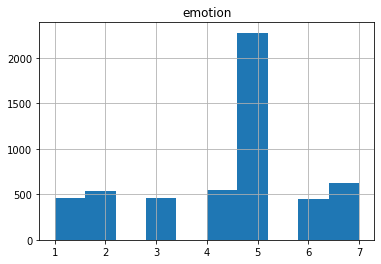

In [10]:
df.hist()

In [11]:
emotionLabelsAll=[]
headlinesAll=[]
urlsAll=[]
for rowIndex in range(0,len(df),BATCH_SIZE):
    try:

        dfBatch=df[rowIndex:rowIndex+BATCH_SIZE]
        headlines=list(dfBatch['headline'].values)
        urls=list(dfBatch.index)

        #Need to store headlines to URLs mapping since headlines longer than threshold will not be labelled
        headlinesToUrlsDict={}
        for headlineIndex, headline in enumerate(headlines):
            headlinesToUrlsDict[headline]=urls[headlineIndex]

        #making sure each headline is no longer than HEADLINE_TOKENS_MAX_LENGTH tokens long
        headlinesBatch=[headline for headline in headlines if (type(headline)==str and len(headline.split())<=MAX_LENGTH)]

        emotionLabels=get_emotion(classifier,headlinesBatch)
        emotionLabelsAll += emotionLabels

        headlinesAll += headlinesBatch

        #Only accumulate URLs of headlines that have been annotated because they fall below the length threshold
        urlsInBatch = [headlinesToUrlsDict[headline] for headline in headlinesBatch]
        urlsAll += urlsInBatch

    except Exception as e:
        print(emotionLabels)
        raise
        print("Something happened in sentence labeling loop", e)
        continue
# dfOut = pd.DataFrame(list(zip(sentimentLabelsAll,headlinesAll,urlsAll)), columns =['sentiment', 'headline','url']) 
# outputFilePath=os.path.join(outputPath,year+'.csv')
# dfOut.to_csv(outputFilePath,index=False)

In [12]:
print(len(emotionLabelsAll),emotionLabelsAll[:100])

5353 [5, 5, 3, 3, 6, 1, 4, 5, 5, 2, 5, 5, 5, 5, 3, 3, 4, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 4, 3, 5, 1, 4, 1, 5, 5, 1, 5, 5, 3, 5, 3, 5, 5, 5, 3, 1, 1, 5, 1, 3, 5, 5, 5, 2, 5, 5, 5, 5, 5, 4, 6, 5, 1, 5, 5, 5, 3, 6, 5, 5, 3, 2, 5, 3, 5, 5, 6, 5, 6, 5, 3, 5, 3, 1, 5, 5, 6, 1, 4, 5, 5, 5, 6, 5, 5, 5, 1, 5]


In [13]:
df.emotion.values

array([3, 5, 5, ..., 7, 5, 5], dtype=int64)

In [14]:
groundTruthLabels=df.emotion.values
print(len(groundTruthLabels),groundTruthLabels[:100])

5353 [3 5 5 5 7 6 6 5 5 2 5 5 2 7 1 1 4 6 7 5 4 3 1 4 7 5 5 1 3 3 7 7 4 4 7 2 6
 7 5 5 3 5 6 5 5 6 3 1 2 1 1 4 7 1 5 1 4 5 5 2 2 5 5 7 2 5 4 5 2 2 6 7 6 3
 5 6 4 6 6 4 3 7 7 5 2 5 3 5 6 2 4 5 1 5 1 5 5 6 1 7]


(array([ 501.,  334.,    0.,  652.,    0.,  264., 2919.,    0.,  566.,
         117.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

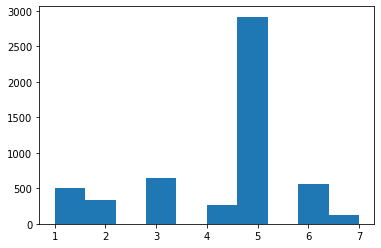

In [15]:
plt.hist(emotionLabelsAll)

(array([ 463.,  540.,    0.,  455.,    0.,  550., 2279.,    0.,  444.,
         622.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

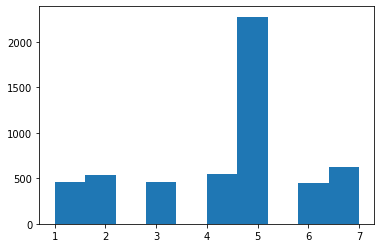

In [16]:
plt.hist(groundTruthLabels)

In [17]:
sklearn.metrics.accuracy_score(emotionLabelsAll,groundTruthLabels)

0.3878199140668784

In [18]:
balanced_accuracy_score(groundTruthLabels, emotionLabelsAll)

0.26990246746666774

In [19]:
sklearn.metrics.f1_score(groundTruthLabels, emotionLabelsAll,average='weighted') #weighted: accounts for class imbalance

0.3608541511567413

In [20]:
sklearn.metrics.precision_recall_fscore_support(groundTruthLabels, emotionLabelsAll,average='weighted')

(0.3719980028289013, 0.3878199140668784, 0.3608541511567413, None)

In [21]:
cohen_kappa_score(groundTruthLabels, emotionLabelsAll)

0.1576149804837671

In [22]:
matthews_corrcoef(groundTruthLabels, emotionLabelsAll)

0.16128823358024497

In [23]:
emotionToNumber={'anger':1,"disgust":2,'fear':3,"joy":4,"neutral":5,"sadness":6,"surprise":7,}

In [24]:
cr=sklearn.metrics.classification_report(groundTruthLabels, emotionLabelsAll,
                                      output_dict=True,
                                      target_names=list(emotionToNumber.keys())
                                     )
cr

{'anger': {'precision': 0.21357285429141717,
  'recall': 0.23110151187904968,
  'f1-score': 0.22199170124481327,
  'support': 463},
 'disgust': {'precision': 0.32335329341317365,
  'recall': 0.2,
  'f1-score': 0.24713958810068648,
  'support': 540},
 'fear': {'precision': 0.2147239263803681,
  'recall': 0.3076923076923077,
  'f1-score': 0.2529358626919603,
  'support': 455},
 'joy': {'precision': 0.3409090909090909,
  'recall': 0.16363636363636364,
  'f1-score': 0.22113022113022113,
  'support': 550},
 'neutral': {'precision': 0.5032545392257622,
  'recall': 0.6445809565598947,
  'f1-score': 0.5652173913043478,
  'support': 2279},
 'sadness': {'precision': 0.22438162544169613,
  'recall': 0.28603603603603606,
  'f1-score': 0.2514851485148515,
  'support': 444},
 'surprise': {'precision': 0.29914529914529914,
  'recall': 0.05627009646302251,
  'f1-score': 0.09472259810554803,
  'support': 622},
 'accuracy': 0.3878199140668784,
 'macro avg': {'precision': 0.302762946972401,
  'recall': 0

In [25]:
df=pd.DataFrame(cr)
df=df.drop('accuracy',axis=1)
# df.iloc[3]=df.iloc[3].apply(int)
dfi.export(df,"../manuscript/figures/sm/emotionModelPerformanceTable.png")
df

,anger,disgust,fear,joy,neutral,sadness,surprise,macro avg,weighted avg
precision,0.213573,0.323353,0.214724,0.340909,0.503255,0.224382,0.299145,0.302763,0.371998
recall,0.231102,0.200000,0.307692,0.163636,0.644581,0.286036,0.056270,0.269902,0.387820
f1-score,0.221992,0.247140,0.252936,0.221130,0.565217,0.251485,0.094723,0.264946,0.360854
support,463.000000,540.000000,455.000000,550.000000,2279.000000,444.000000,622.000000,5353.000000,5353.000000


<Figure size 360x360 with 0 Axes>

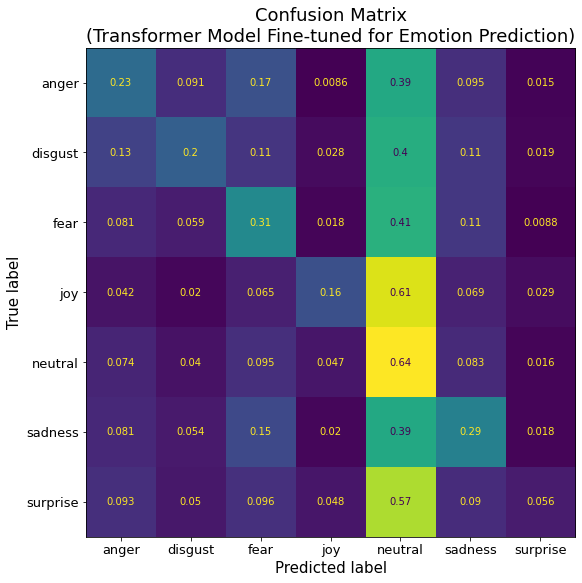

In [30]:
plt.figure(figsize=(5,5))

plt.rcParams["figure.figsize"] = [16,9]
cm=sklearn.metrics.confusion_matrix(groundTruthLabels,emotionLabelsAll,
                                     normalize='true'
                                    )
cmd=sklearn.metrics.ConfusionMatrixDisplay(cm,display_labels=emotionToNumber.keys(),)
cmd.plot()
# cmd.im_.set_clim(0, 1)
cmd.im_.colorbar.remove()
plt.xticks(fontsize=13);plt.yticks(fontsize=13);
plt.xlabel("Predicted label", fontsize=15); plt.ylabel("True label", fontsize=15)
plt.title("Confusion Matrix\n(Transformer Model Fine-tuned for Emotion Prediction)", fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('../manuscript/figures/sm/Confusion matrix of emotion model.jpg',dpi=300,bbox_inches='tight',pad_inches=0.0)

In [28]:
cm=sklearn.metrics.confusion_matrix(groundTruthLabels,emotionLabelsAll,normalize=None)


In [29]:
pClass=cm.sum(axis=1)/len(groundTruthLabels)
pClass

array([0.08649356, 0.10087801, 0.08499907, 0.10274612, 0.42574257,
       0.08294414, 0.11619653])

In [30]:
pPrediction=cm.sum(axis=0)/len(groundTruthLabels)
pPrediction

array([0.09359238, 0.06239492, 0.12180086, 0.04931814, 0.5453017 ,
       0.1057351 , 0.0218569 ])

In [31]:
pChance=pClass*pPrediction
pChance

array([0.00809514, 0.00629428, 0.01035296, 0.00506725, 0.23215815,
       0.00877011, 0.0025397 ])

In [32]:
pE_ChanceFinal=pChance.sum()
pE_ChanceFinal

0.2732775729028443

In [34]:
probDist=[cr[e]['support']/len(emotionLabelsAll) for e in emotionToNumber.keys()]
probDist

[0.08649355501587895,
 0.10087801232953485,
 0.08499906594433028,
 0.10274612366897067,
 0.42574257425742573,
 0.08294414347095087,
 0.11619652531290865]

In [35]:
randomGuessing=np.random.choice(7, len(emotionLabelsAll), p=probDist)
randomGuessing=randomGuessing+1

In [36]:
crRandomGuessing=sklearn.metrics.classification_report(groundTruthLabels, randomGuessing,
                                      output_dict=True,
                                      target_names=list(emotionToNumber.keys())
                                     )
crRandomGuessing

{'anger': {'precision': 0.08061002178649238,
  'recall': 0.07991360691144708,
  'f1-score': 0.08026030368763558,
  'support': 463},
 'disgust': {'precision': 0.11209964412811388,
  'recall': 0.11666666666666667,
  'f1-score': 0.11433756805807622,
  'support': 540},
 'fear': {'precision': 0.09896907216494845,
  'recall': 0.1054945054945055,
  'f1-score': 0.10212765957446808,
  'support': 455},
 'joy': {'precision': 0.1282051282051282,
  'recall': 0.12727272727272726,
  'f1-score': 0.12773722627737225,
  'support': 550},
 'neutral': {'precision': 0.43172779496243924,
  'recall': 0.4286967968407196,
  'f1-score': 0.43020695728753855,
  'support': 2279},
 'sadness': {'precision': 0.09744779582366589,
  'recall': 0.0945945945945946,
  'f1-score': 0.096,
  'support': 444},
 'surprise': {'precision': 0.10543657331136738,
  'recall': 0.10289389067524116,
  'f1-score': 0.10414971521562245,
  'support': 622},
 'accuracy': 0.24304128526060154,
 'macro avg': {'precision': 0.15064229005459362,
  'r

In [37]:
df2=pd.DataFrame(crRandomGuessing)
df2=df2.drop('accuracy',axis=1)
# df.iloc[3]=df.iloc[3].apply(int)
dfi.export(df2,"../manuscript/figures/sm/randomGuessingPerformanceTable.png")
df2

,anger,disgust,fear,joy,neutral,sadness,surprise,macro avg,weighted avg
precision,0.080610,0.112100,0.098969,0.128205,0.431728,0.097448,0.105437,0.150642,0.244004
recall,0.079914,0.116667,0.105495,0.127273,0.428697,0.094595,0.102894,0.150790,0.243041
f1-score,0.080260,0.114338,0.102128,0.127737,0.430207,0.096000,0.104150,0.150688,0.243503
support,463.000000,540.000000,455.000000,550.000000,2279.000000,444.000000,622.000000,5353.000000,5353.000000
